# Background

There are several options for analyzing the image data. Below are a few links which may be helpful:
* [K-Means Clustering to find dominant images](https://www.pyimagesearch.com/2014/05/26/opencv-python-k-means-color-clustering/)
* [Wikipedias page on color quantization](https://www.wikiwand.com/en/Color_quantization)
* [Colorgram (python package based on median cut](https://cloud.google.com/vision/)
* [Deep learning with OpenCV to classify objects](https://www.pyimagesearch.com/2017/08/21/deep-learning-with-opencv/)
* [Google's Cloud Vision API](https://cloud.google.com/vision/)
* [Sysnets for tensor flow](http://image-net.org/challenges/LSVRC/2014/browse-synsets)
* [Tensor flow](https://www.tensorflow.org/tutorials/image_recognition)

Some other ideas for quantifying the image complexity:
* https://www.reddit.com/r/compsci/comments/5zyb0t/calculate_image_complexity/
* https://www.wikiwand.com/en/Gabor_filter (has numpy code)
* http://nbviewer.jupyter.org/github/bicv/LogGabor/blob/master/LogGabor.ipynb

# Imports

In [71]:
%matplotlib inline
import matplotlib
import seaborn as sns

from time import time

import requests
from bs4 import BeautifulSoup
import re

from collections import deque

# download the image to buffer
from PIL import Image
import io

# converting the img to numpy and displaying it
import numpy as np
import matplotlib
from matplotlib import pyplot as plt


from sklearn import cluster
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.utils import shuffle

from skimage import color as skcolor
from skimage import filters
from skimage import morphology

# bokeh version
import pandas as pd
from bokeh.models import ColumnDataSource
import bokeh.plotting as bkplt
import bokeh as bk
from bokeh.io import output_notebook

output_notebook()

# Plotly
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

#import pandas as pd

plotly.offline.init_notebook_mode(connected=True)

Loading BokehJS ...

# Get Image

In [2]:
url = r'https://www.ttbonline.gov/colasonline/viewColaDetails.do'
params = {'action': 'publicFormDisplay',
          'ttbid': 16306001000152}
response = requests.get(url, params=params)
soup = BeautifulSoup(response.text, 'html5lib')

imgs = soup.select('img[alt*=Label]')
img_url = r'https://www.ttbonline.gov' + imgs[0]['src']

In [3]:
headers = {'Host': 'www.ttbonline.gov',
           'Connection': 'keep-alive',
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
           'Accept': 'image/webp,image/apng,image/*,*/*;q=0.8',
           'DNT': '1',
           'Referer': 'https://www.ttbonline.gov/colasonline/viewColaDetails.do?action=publicFormDisplay&ttbid=17115001000140',
           'Accept-Encoding': 'gzip, deflate, br',
           'Accept-Language': 'en-US,en;q=0.8',
           'Cookie': 'JSESSIONID={JSESSIONID}; ADRUM=s=1505843347648&r=https%3A%2F%2Fwww.ttbonline.gov%2Fformulasonline%2Fur.do; _ga=GA1.2.85013097.1505831436; _gid=GA1.2.1148469331.150609453'.format(JSESSIONID=response.cookies.values()[0])
           }

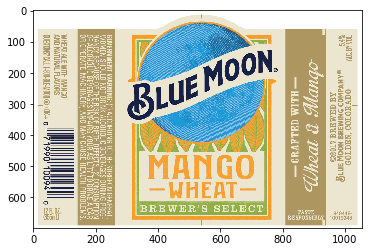

In [4]:
r = requests.get(img_url, headers=headers)
pimg = Image.open(io.BytesIO(r.content))
img = np.array(pimg)
plt.imshow(img)
plt.show()

# Image Properties

In [7]:
pimg.format

'JPEG'

In [74]:
res = pimg.convert('HSV')
resnp = np.array(res)

# Histograms

Histogram w/ HSV

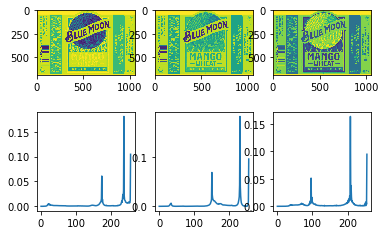

In [77]:
pdf = [None]*3

for i in range(3):
    pdf[i], _ = np.histogram(img[:,:,i].ravel(), bins=256, range=(0.0, 256), density=True)
    
    plt.subplot(2, 3, i+1)
    plt.imshow(img[:,:,i])
    plt.subplot(2, 3, i+4)
    plt.plot(pdf[i])
   
plt.show()

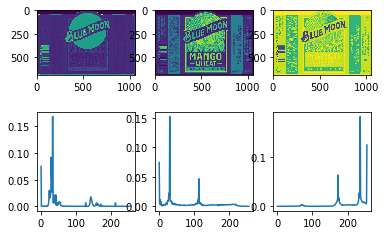

In [76]:
pdf = [None]*3

for i in range(3):
    pdf[i], _ = np.histogram(resnp[:,:,i].ravel(), bins=256, range=(0.0, 256), density=True)
    
    plt.subplot(2, 3, i+1)
    plt.imshow(resnp[:,:,i])
    plt.subplot(2, 3, i+4)
    plt.plot(pdf[i])
   
plt.show()

# Dominant colors

Dominant color selection is actually a non-trivial problem. As described in [this blog post](http://blog.zeevgilovitz.com/detecting-dominant-colours-in-python/) kmeans tackles the problem of over exposure in pictures. Since our labels aren't pictures, this may not be an issue, but his results are good!

[The wiki page on color quantization](https://www.wikiwand.com/en/Color_quantization)

[A color quantization program (C#) that covers most methods](https://www.codeproject.com/Articles/66341/A-Simple-Yet-Quite-Powerful-Palette-Quantizer-in-C)

https://blog.library.si.edu/2017/09/creating-colors-image-gallery/#.WcbnttOGPXE

### KMeans

http://www.pyimagesearch.com/2014/05/26/opencv-python-k-means-color-clustering/

In [5]:
def centroid_histogram(clt):
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = len(np.unique(clt.labels_))
    (hist, _) = np.histogram(clt.cluster_centers_, bins = numLabels)

    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()

    # return the histogram (percentage described by each cluster)
    return hist.reshape(numLabels,1)

## Sci-kit-learn:  KMeans

http://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html#sphx-glr-auto-examples-cluster-plot-color-quantization-py

##### Scale image so there is less to process

In [59]:
thumbnail = Image.Image.copy(pimg)

In [60]:
thumbnail.thumbnail((128,128))

Size: (84, 128, 3)


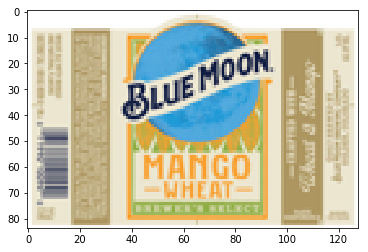

In [61]:
thumb = np.array(thumbnail)
plt.imshow(thumb)
print('Size: {}'.format(thumb.shape))
plt.show()

#### Basic kmeans

In [114]:
t0 = time()

n_colors=7

thumb = np.array(thumb)
w, h, d = original_shape = tuple(thumb.shape)
assert d == 3
image_array = np.reshape(thumb, (w * h, d))

image_array_sample = shuffle(image_array, random_state=0)[:1000]  # take a random sample of 1000 points

cluster_labels = cluster.KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

print("KMeans completed in: %0.3fs." % (time() - t0))

hist = centroid_histogram(cluster_labels)

KMeans completed in: 0.053s.


#### Visualize results

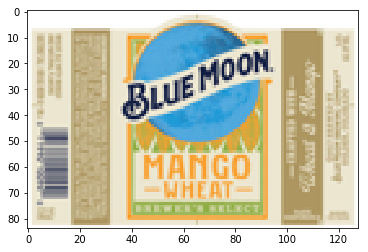

In [115]:
fig = bkplt.figure()

x_offset = 0
for (percentage, color) in zip(hist, cluster_labels.cluster_centers_):
    #print('{}-{}-{}'.format(x_offset, percentage,color))
    fig.quad(left=x_offset, right=x_offset+percentage, top=0.5, bottom=-0.5, fill_color=tuple(color))
    x_offset += percentage[0]

bkplt.show(fig)

plt.imshow(thumb)
plt.show()

### Convert to function for further experimentation

In [9]:
def kmeans_color (img, max_colors=10, n_init=25, verbose=False):
    """
    Calculates the dominant colors in an image using kmeans
    
    :param img: numpy array shape (n,m,3)
    :param max_colors: the maximum number of possible colors to get out
    :param n_init: the number of different starting positions to try for kmeans
    :param verbose: output info when running
    :return hist: fraction of image that each color represents
    :return clusters.cluster_centers_: the 3 tuple values
    """
    t0 = time()
    
    w, h, d = original_shape = tuple(img.shape)
    assert d == 3
    image_array = np.reshape(img, (w * h, d))

    image_array_sample = shuffle(image_array, random_state=0)[:1000]  # take a random sample of 1000 points

    rand_state = 0  # same randome state is used for repeatability

    bestSilhouette = 0
    for n_colors in range(2, 10):
        clt = cluster.KMeans(n_clusters=n_colors, random_state=rand_state, n_init=n_init)
        clt.fit(image_array_sample)
        silhouette = silhouette_score(image_array_sample, clt.labels_, metric='euclidean')

        # Find the best one
        if silhouette > bestSilhouette:
            bestSilhouette = silhouette
            best_nClusters = n_colors;
    if verbose:
        print("KMeans completed in: %0.3fs." % (time() - t0))
        print("Optimal number of clusters:  {}".format(best_nClusters))

    clt = cluster.KMeans(n_clusters=best_nClusters, random_state=rand_state, n_init=n_init)
    clusters = clt.fit(image_array_sample)
    hist = centroid_histogram(clusters)
    
    return hist, clusters.cluster_centers_

In [11]:
def visualize_dom_colors(percentages, colors, img):
    """
    Create a plot of the dominant colors, where size of swatch represents proportion of that color
    
    Please excuse the horrendous mixing of bokeh and matplotlib
    """
    
    fig = bkplt.figure()

    x_offset = 0
    for (percentage, color) in zip(percentages, colors):
        #print('{}-{}-{}'.format(x_offset, percentage,color))
        fig.quad(left=x_offset, right=x_offset+percentage, top=0.5, bottom=-0.5, fill_color=tuple(color))
        x_offset += percentage[0]

    
    bkplt.show(fig)
    plt.imshow(img)
    plt.show()

# Testing color space

### RGB

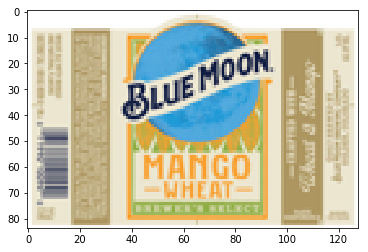

In [12]:
thumbnail = Image.Image.copy(pimg)  # deep copy original image
thumbnail.thumbnail((128,128))  # scale to create a thumbnail

thumbnail = np.array(thumbnail)

res = kmeans_color(thumbnail)
visualize_dom_colors(*res, thumbnail)

### HSV

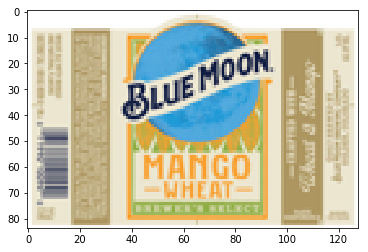

In [68]:
thumbnail = Image.Image.copy(pimg)  # deep copy original image
thumbnail.thumbnail((128,128))  # scale to create a thumbnail
thumbnail = np.array(thumbnail)

perc, col = kmeans_color(skcolor.rgb2hsv(thumbnail))

col = np.array([skcolor.hsv2rgb(ele.reshape(1,1,3)) for ele in col])
col = [t[0][0]*255 for t in col]

visualize_dom_colors(perc, col, thumbnail)

# Calculate entropy of image

/opt/conda/envs/datainc/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning:

Possible precision loss when converting from float64 to uint8



Total entropy: 39852.831078903706


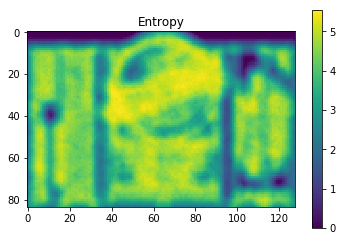

In [81]:
thumbnail = Image.Image.copy(pimg)  # deep copy original image
thumbnail.thumbnail((128,128))  # scale to create a thumbnail
thumbnail = np.array(thumbnail)

thumbnail = color.rgb2grey(thumbnail)

ent = filters.rank.entropy(thumbnail, morphology.disk(4))

print('Total entropy: {}'.format(np.sum(ent)))

plt.imshow(ent)
plt.title('Entropy')
plt.colorbar()
plt.show()


### Convert output to pandas

In [215]:
df

,percent,R,G,B
0,0.100000,235.846784,229.579020,206.657910
1,0.100000,152.224700,174.904402,72.322335
2,0.033333,47.694989,149.720076,202.996837
3,0.100000,25.518758,34.644480,68.140452
4,0.000000,172.231681,152.008039,100.340302
5,0.200000,254.384697,254.473008,253.640769
6,0.066667,243.790368,161.187505,51.182998
7,0.166667,108.303121,187.595826,240.583224
8,0.033333,205.050395,189.863686,150.684138
9,0.200000,56.948798,105.731848,141.578868


In [ ]:
pd.DataFrame(np.concatenate())